# Computing polygenic risk scores using LDpred2

This polygenic risk scores (PRS) tutorial was developed using GWAS summary statistics, and 1000 Genome. 

As an exmple in this tutorial, we used the 483 European samples from 1000 Genome project and GWAS data of height to calculate PRS.

If you do not have enough data to use as LD reference, the author of LDpred2 provided an [LD reference](https://figshare.com/articles/dataset/European_LD_reference/13034123) that can be used directly.

## Data description download link
The data are stored in a directory called "tmp-data". 

    GWAS: height; SNPs on chromosome 2.
    1000 Genome: 483 European samples, 489805 SNPs.
    HapMap3: 1120696 SNPs.

## Load R package `bigsnpr`

In [1]:
# Load packages bigsnpr and bigstatsr
library(bigsnpr)

Loading required package: bigstatsr



## Load genotype data and summary statistics

### Obtain HapMap3 SNPs
In practice, until we find a better set of variants, we recommend using the HapMap3 variants used in PRS-CS and the LDpred2 papers.

SNPs present on the 1000 Genomes reference panel and the HapMap3 panel were kept to calculate PRS.

In [15]:
info <- readRDS(url("https://github.com/privefl/bigsnpr/raw/master/data-raw/hm3_variants.rds"))

There are 1120696 SNPs.

In [19]:
dim(info)

[1] 1120696       8

In [22]:
head(info)

,chr,rsid,pos,a1,a0,maf,pos_hg19,pos_hg17
,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<int>
1,1,rs3131972,752721,A,G,0.16100,762858,802721
2,1,rs3131969,754182,A,G,0.12820,764319,804182
3,1,rs1048488,760912,C,T,0.16000,771049,810912
4,1,rs12562034,768448,A,G,0.09245,778585,818448
5,1,rs4040617,779322,G,A,0.11830,789459,829322
6,1,rs4970383,838555,A,C,0.23860,848692,888555


### Obtain summary statistic and merge with HapMap3
To match variants contained in genotype data and summary statistics, the variables "chr" (chromosome number), "pos" (genetic position), "a0" (reference allele) and "a1" (derived allele) should be available in the summary statistics and in the genotype data. These 4 variables are used to match variants between the two data frames.

In [11]:
# Read summary statistic
sumstats <- bigreadr::fread2("post-qc/Height.QC.gz") 
# Rename headers required by LDpred2
names(sumstats) <- c("chr", "pos", "rsid", "a1", "a0", "n_eff", "beta_se", "p", "OR", "INFO", "MAF")
# Transform the OR into log(OR)
sumstats$beta <- log(sumstats$OR)

In [13]:
nrow(sumstats)

[1] 499617

Keep GWAS SNPs that match with HapMap3.

In [16]:
sumstats <- sumstats[sumstats$rsid %in% info$rsid,]

In [18]:
nrow(sumstats)

[1] 136004

In [17]:
head(sumstats)

,chr,pos,rsid,a1,a0,n_eff,beta_se,p,OR,INFO,MAF,beta
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,1,768448,rs12562034,A,G,388028,0.00329472,0.834808000,1.0006873,0.8958935,0.3368458,0.00068708
3,1,779322,rs4040617,G,A,388028,0.00303344,0.428970000,0.9976036,0.8975083,0.3773680,-0.00239932
8,1,838555,rs4970383,A,C,388028,0.00235773,0.150993000,0.9966199,0.9077165,0.3271640,-0.00338578
18,1,873558,rs1110052,G,T,388028,0.00225578,0.000285674,0.9918494,0.9004758,0.3680888,-0.00818396
19,1,880238,rs3748592,A,G,388028,0.00450310,0.488653000,1.0031231,0.8728364,0.4104163,0.00311819
20,1,880390,rs3748593,A,C,388028,0.00635197,0.272881000,0.9930596,0.8992809,0.4930243,-0.00696463


## Perform SNP matching between 1000 Genome and summary statistics. 

In [25]:
# Get maximum amount of cores
NCORES <- nb_cores()
# Open a temporary file
tmp <- tempfile(tmpdir = "tmp-data")

In [26]:
# Initialize variables for storing the LD score and LD matrix
corr <- NULL
ld <- NULL
# We want to know the ordering of samples in the bed file 
fam.order <- NULL

In [27]:
# Obtain the genotype object
obj.bigSNP <- snp_attach("post-qc/EUR.QC.rds")

We used SNP map in 1000 Genome. Here, we have 489805 SNPs.

In [29]:
names(obj.bigSNP)

[1] "genotypes" "fam"       "map"

In [31]:
dim(obj.bigSNP$genotypes)

[1]    483 489805

In [33]:
head(obj.bigSNP$map)

,chromosome,marker.ID,genetic.dist,physical.pos,allele1,allele2
,<int>,<chr>,<dbl>,<int>,<chr>,<chr>
1,1,rs3131962,0.490722,756604,A,G
2,1,rs4040617,0.500708,779322,G,A
3,1,rs79373928,0.587220,801536,G,T
4,1,rs11240779,0.620827,808631,G,A
5,1,rs57181708,0.620827,809876,G,A
6,1,rs4422948,0.620827,835499,G,A


In [66]:
dim(obj.bigSNP$map)

[1] 489805      6

In [68]:
# Extract the SNP information from the genotype
map <- obj.bigSNP$map[-3]
# Rename columns
names(map) <- c("chr", "rsid", "pos", "a1", "a0")

Match SNPs from GWAS SNPs (already matched with HapMap3) with 1000 Genome.

There are 134522 SNPs matched.

In [35]:
info_snp <- snp_match(sumstats, map)

136,004 variants to be matched.

0 ambiguous SNPs have been removed.

134,522 variants have been matched; 0 were flipped and 91 were reversed.



In [41]:
head(info_snp)

,chr,pos,a0,a1,rsid.ss,n_eff,beta_se,p,OR,INFO,MAF,beta,_NUM_ID_.ss,rsid,_NUM_ID_
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>
1,1,779322,A,G,rs4040617,388028,0.00303344,0.428970000,0.9976036,0.8975083,0.3773680,-0.00239932,2,rs4040617,2
2,1,838555,C,A,rs4970383,388028,0.00235773,0.150993000,0.9966199,0.9077165,0.3271640,-0.00338578,3,rs4970383,7
3,1,873558,T,G,rs1110052,388028,0.00225578,0.000285674,0.9918494,0.9004758,0.3680888,-0.00818396,4,rs1110052,17
4,1,880238,G,A,rs3748592,388028,0.00450310,0.488653000,1.0031231,0.8728364,0.4104163,0.00311819,5,rs3748592,18
5,1,880390,C,A,rs3748593,388028,0.00635197,0.272881000,0.9930596,0.8992809,0.4930243,-0.00696463,6,rs3748593,19
6,1,888659,C,T,rs3748597,388028,0.00450334,0.532409000,1.0028155,0.9041076,0.4979493,0.00281159,7,rs3748597,23


In [69]:
dim(info_snp)

[1] 134522     15

In [36]:
# Assign the genotype to a variable for easier downstream analysis
genotype <- obj.bigSNP$genotypes
# Rename the data structures
CHR <- map$chr
POS <- map$pos

### Correlation
You need to compute correlations between variants. We recommend to use a window size of 3 cM.

In [37]:
# get the CM information from 1000 Genome
POS2 <- snp_asGeneticPos(CHR, POS, dir = ".")

## Calculate the LD matrix
In practice, you need to build it for variants from all chromosomes.

In this example, we built the LD matrix using variants from one chromosome only (chromosome 2). But we calculate LD matrices for all chromosomes and saved them. If you only need a particular chrosome, just change the `for loop` in the first line.

In [38]:
# calculate LD matrix for chromosome 1 to 22. If you only need a particular chromosome, just change the for loop.
for (chr in 1:22) {
    # Extract SNPs that are included in the chromosome
    ind.chr <- which(info_snp$chr == chr)
    ind.chr2 <- info_snp$`_NUM_ID_`[ind.chr]
    # Calculate the LD
    corr0 <- snp_cor(genotype, ind.col = ind.chr2,  ncores = NCORES, infos.pos = POS2[ind.chr2], size = 3 / 1000)
    if (chr == 1) {
        ld <- Matrix::colSums(corr0^2)
        corr <- as_SFBM(corr0, tmp)
    } 
    else {
        ld <- c(ld, Matrix::colSums(corr0^2))
        corr$add_columns(corr0, nrow(corr))
    }
}

In [43]:
dim(corr)

[1] 134522 134522

In [39]:
# We assume the fam order is the same across different chromosomes
fam.order <- as.data.table(obj.bigSNP$fam)
# Rename fam order
setnames(fam.order, c("family.ID", "sample.ID"), c("FID", "IID"))

## LD score regression

In [40]:
df_beta <- info_snp[,c("beta", "beta_se", "n_eff", "_NUM_ID_")]

In [42]:
head(df_beta)

,beta,beta_se,n_eff,_NUM_ID_
,<dbl>,<dbl>,<int>,<int>
1,-0.00239932,0.00303344,388028,2
2,-0.00338578,0.00235773,388028,7
3,-0.00818396,0.00225578,388028,17
4,0.00311819,0.00450310,388028,18
5,-0.00696463,0.00635197,388028,19
6,0.00281159,0.00450334,388028,23


In [44]:
dim(df_beta)

[1] 134522      4

In [45]:
## snp_ldsc from library bigsnpr
ldsc <- snp_ldsc(ld, length(ld), chi2 = (df_beta$beta / df_beta$beta_se)^2, sample_size = df_beta$n_eff, blocks = NULL)
h2_est <- ldsc[["h2"]]
h2_est

[1] 0.4485721

## Estimate the adjusted beta

### Infinitesimal Model

In [46]:
beta_inf <- snp_ldpred2_inf(corr, df_beta, h2 = h2_est)
summary(beta_inf)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-6.085121 -0.002012 -0.000006  0.000915  0.002009  6.981044 

In [47]:
length(beta_inf)

[1] 134522

### Grid of models

In [48]:
# Prepare data for grid model
p_seq <- signif(seq_log(1e-4, 1, length.out = 17), 2)
h2_seq <- round(h2_est * c(0.7, 1, 1.4), 4)
grid.param <- expand.grid(p = p_seq, h2 = h2_seq, sparse = c(FALSE, TRUE))

In [ ]:
beta_grid <- snp_ldpred2_grid(corr, df_beta, grid.param, ncores = NCORES)

### Auto model

In [50]:
multi_auto <- snp_ldpred2_auto(corr, df_beta, h2_init = h2_est, vec_p_init = seq_log(1e-4, 0.9, length.out = NCORES), ncores = NCORES)
beta_auto <- sapply(multi_auto, function(auto) auto$beta_est)

In [52]:
summary(beta_auto)

       V1                   V2                   V3            
 Min.   :-6.008e-02   Min.   :-6.018e-02   Min.   :-6.007e-02  
 1st Qu.:-1.324e-03   1st Qu.:-1.324e-03   1st Qu.:-1.322e-03  
 Median :-5.130e-06   Median :-5.320e-06   Median :-5.580e-06  
 Mean   : 2.760e-05   Mean   : 2.734e-05   Mean   : 2.724e-05  
 3rd Qu.: 1.328e-03   3rd Qu.: 1.326e-03   3rd Qu.: 1.325e-03  
 Max.   : 1.217e-01   Max.   : 1.223e-01   Max.   : 1.219e-01  
       V4                   V5                   V6            
 Min.   :-6.016e-02   Min.   :-6.015e-02   Min.   :-6.017e-02  
 1st Qu.:-1.321e-03   1st Qu.:-1.321e-03   1st Qu.:-1.322e-03  
 Median :-6.380e-06   Median :-6.730e-06   Median :-5.380e-06  
 Mean   : 2.763e-05   Mean   : 2.753e-05   Mean   : 2.747e-05  
 3rd Qu.: 1.327e-03   3rd Qu.: 1.326e-03   3rd Qu.: 1.324e-03  
 Max.   : 1.219e-01   Max.   : 1.220e-01   Max.   : 1.217e-01  
       V7            
 Min.   :-6.019e-02  
 1st Qu.:-1.322e-03  
 Median :-8.230e-06  
 Mean   : 2.747e

## Calculate PRS

### Infinitesimal Model

In [53]:
if(is.null(obj.bigSNP)){
    obj.bigSNP <- snp_attach("EUR.QC.rds")
}
genotype <- obj.bigSNP$genotypes
# calculate PRS for all samples
ind.test <- 1:nrow(genotype)
pred_inf <- big_prodVec(genotype, beta_inf, ind.row = ind.test, ind.col = info_snp$`_NUM_ID_`)

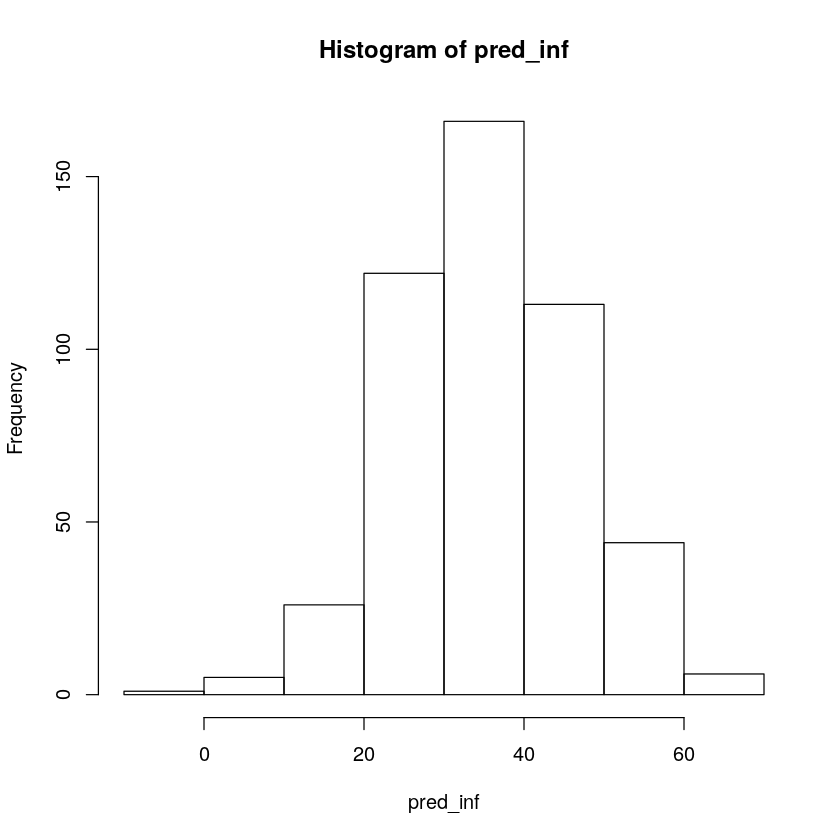

In [54]:
hist(pred_inf)

In [55]:
length(pred_inf)

[1] 483

In [56]:
length(pred_inf[which(pred_inf>0)])

[1] 482

### Grid of models

In [57]:
if(is.null(obj.bigSNP)){
    obj.bigSNP <- snp_attach("EUR.QC.rds")
}
# calculate PRS for all samples
ind.test <- 1:nrow(genotype)
pred_grid <- big_prodMat(genotype, beta_grid, ind.col = info_snp$`_NUM_ID_`)

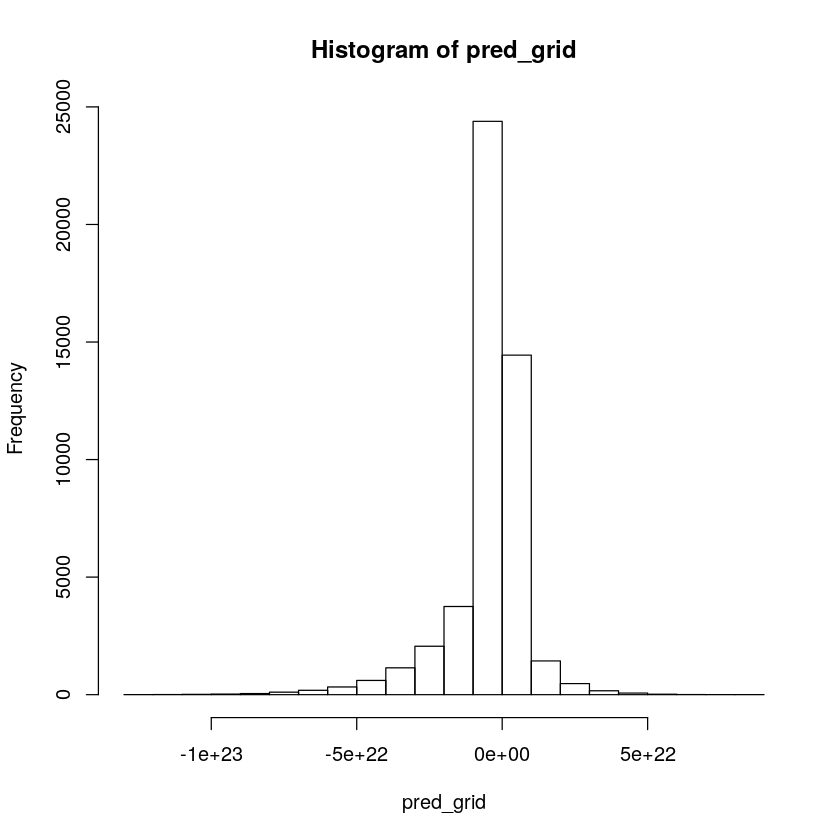

In [58]:
hist(pred_grid)

In [60]:
length(pred_grid)

[1] 49266

In [59]:
length(pred_grid[which(pred_grid>0)])

[1] 20426

### Auto model

In [61]:
if(is.null(obj.bigSNP)){
    obj.bigSNP <- snp_attach("EUR.QC.rds")
}
# calculate PRS for all samples
ind.test <- 1:nrow(genotype)
pred_auto <-
    big_prodMat(genotype,
                beta_auto,
                ind.row = ind.test,
                ind.col = info_snp$`_NUM_ID_`)
# scale the PRS generated from AUTO
pred_scaled <- apply(pred_auto, 2, sd)
final_beta_auto <-
    rowMeans(beta_auto[,
                abs(pred_scaled -
                    median(pred_scaled)) <
                    3 * mad(pred_scaled)])
pred_auto <-
    big_prodVec(genotype,
        final_beta_auto,
        ind.row = ind.test,
        ind.col = info_snp$`_NUM_ID_`)

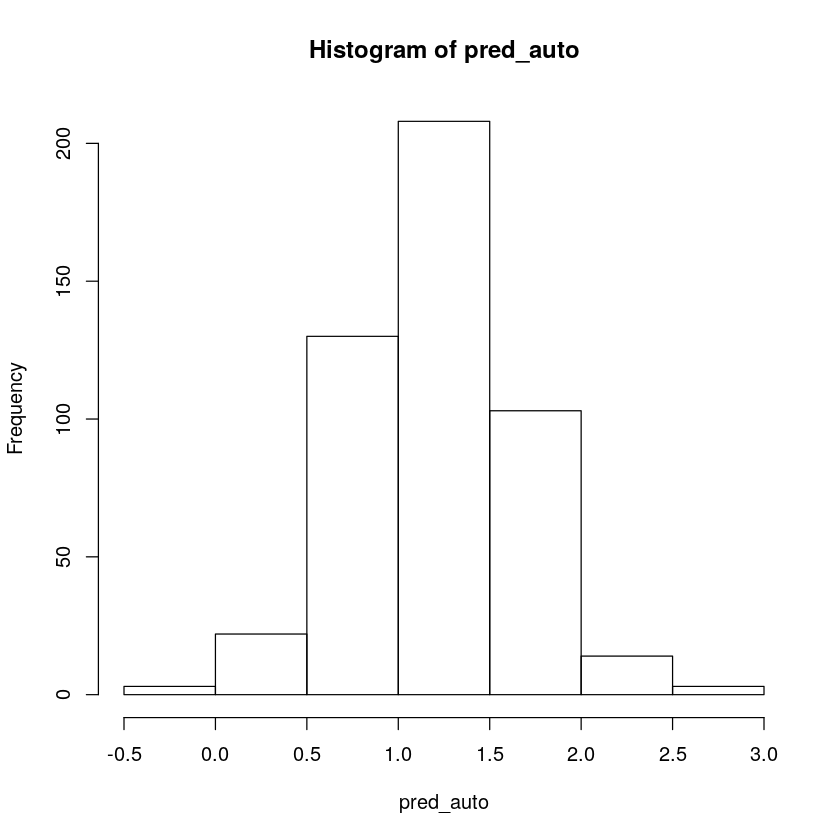

In [62]:
hist(pred_auto)

In [63]:
length(pred_auto)

[1] 483

In [64]:
length(pred_auto[which(pred_auto>0)])

[1] 480